# Explore Scratchpad
This notebook is where I am working through my messy exploration stage of the zillow data and testing modules developed so far.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from env import host, user, password
import evaluate
import prepare
import acquire
import os
from math import sqrt
import math

from scipy import stats

import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.formula.api import ols

# Handle large numbers w/o using scientific notation
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Acquire the data
df = acquire.get_zillow_data(cached=False)
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,latitude,longitude,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,unitcnt,propertylandusetypeid,propertylandusedesc
0,11721753,2.000,3.000,2.000,1316.000,6037.000,34033180.000,-118355396.000,41948.000,205123.000,163175.000,2627.480,1.000,261.000,Single Family Residential
1,11289917,2.000,3.000,2.000,1458.000,6037.000,34686163.000,-118113100.000,108890.000,136104.000,27214.000,2319.900,1.000,261.000,Single Family Residential
2,11637029,2.000,3.000,2.000,1766.000,6037.000,34073222.000,-118390965.000,256538.000,810694.000,554156.000,9407.010,1.000,266.000,Condominium
3,11705026,1.000,2.000,1.000,1421.000,6037.000,33999877.000,-118291863.000,11982.000,35606.000,23624.000,543.690,1.000,261.000,Single Family Residential
4,11446756,2.000,3.000,2.000,1491.000,6037.000,33873860.000,-118338253.000,60537.000,107110.000,46573.000,1399.270,1.000,261.000,Single Family Residential


In [3]:
#Clean and Prepare the data
df = prepare.prepare_zillow(df)

In [4]:
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
parcelid,,,,
11721753,2.000,3.000,1316.000,205123.000
11289917,2.000,3.000,1458.000,136104.000
11637029,2.000,3.000,1766.000,810694.000
11705026,1.000,2.000,1421.000,35606.000
11446756,2.000,3.000,1491.000,107110.000


In [5]:
df.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
count,24947.000,24947.000,24947.000,24947.000
mean,2.252,2.960,1709.307,480768.967
std,0.994,1.006,944.334,683040.615
min,0.000,0.000,240.000,1000.000
25%,2.000,2.000,1144.000,188000.000
50%,2.000,3.000,1480.000,334959.000
75%,3.000,4.000,1988.000,543906.000
max,11.000,11.000,35640.000,23858374.000


In [6]:
# Calculate the interquartile range for your column

q1, q3 = df.taxvaluedollarcnt.quantile([.25, .75])

iqr = q3 - q1

# Create variables holding upper and lower cutoff values using common formula. Tweak as you like.

upperbound = q3 + 3 * iqr

lowerbound = q1 - 3 * iqr

upperbound, lowerbound

(1611624.0, -879718.0)

In [7]:
# Filter the column using your variables and reassign to your dataframe.

df = df[df.taxvaluedollarcnt < upperbound]


In [8]:
df.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
count,24084.000,24084.000,24084.000,24084.000
mean,2.180,2.921,1625.974,391340.203
std,0.881,0.976,731.057,292548.274
min,0.000,0.000,240.000,1000.000
25%,2.000,2.000,1133.000,182744.000
50%,2.000,3.000,1455.000,324572.500
75%,3.000,3.000,1919.000,512559.500
max,10.000,11.000,7942.000,1610000.000


In [9]:
df.shape

(24084, 4)

In [10]:
#Split the data
train, test, validate = prepare.split_stratify_continuous(df, 'taxvaluedollarcnt', bins=5)
train.shape, test.shape, validate.shape

((13486, 4), (4817, 4), (5781, 4))

In [11]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
parcelid,,,,
11348913,3.000,4.000,2829.000,557064.000
12507741,3.000,2.000,1315.000,300258.000
12213784,1.000,2.000,992.000,20865.000
11628655,2.000,2.000,1484.000,401186.000
10981423,4.000,5.000,4010.000,1075000.000


<AxesSubplot:xlabel='taxvaluedollarcnt'>

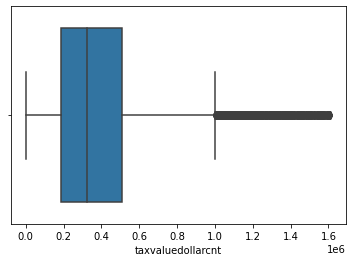

In [12]:
#Box and whisker for tax value dollar count
sns.boxplot(train.taxvaluedollarcnt)

In [13]:
#Scale the data

#Create the object
scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.

scaler.fit(train)

train_scaled = scaler.transform(train)
validate_scaled = scaler.transform(validate)
test_scaled = scaler.transform(test)

In [14]:
# turn the numpy arrays into dataframes
train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
validate_scaled = pd.DataFrame(validate_scaled, columns=train.columns)
test_scaled = pd.DataFrame(test_scaled, columns=train.columns)

In [15]:
train_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
0,0.333,0.500,0.364,0.346
1,0.333,0.250,0.151,0.186
2,0.111,0.250,0.106,0.012
3,0.222,0.250,0.175,0.249
4,0.444,0.625,0.531,0.667


In [16]:
train_scaled.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
count,13486.000,13486.000,13486.000,13486.000
mean,0.241,0.364,0.194,0.243
std,0.097,0.121,0.102,0.181
min,0.000,0.000,0.000,0.000
25%,0.222,0.250,0.125,0.115
50%,0.222,0.375,0.171,0.201
75%,0.333,0.375,0.234,0.317
max,1.000,1.000,1.000,1.000


Text(0.5, 1.0, 'Scaled')

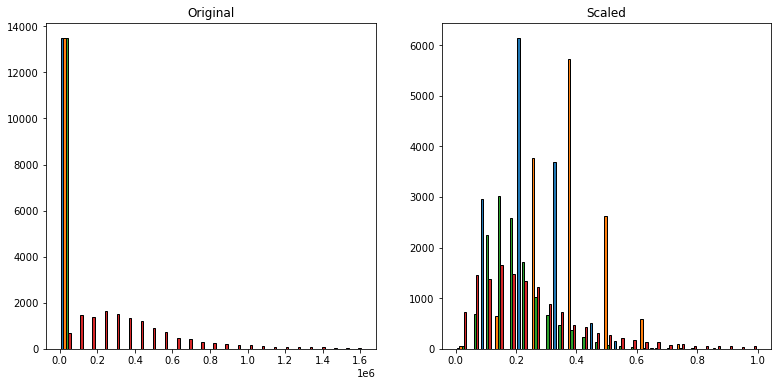

In [17]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(train_scaled, bins=25, ec='black')
plt.title('Scaled')

<AxesSubplot:>

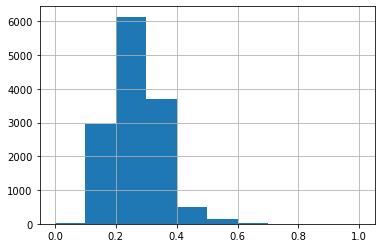

In [18]:
train_scaled.bathroomcnt.hist()

<AxesSubplot:>

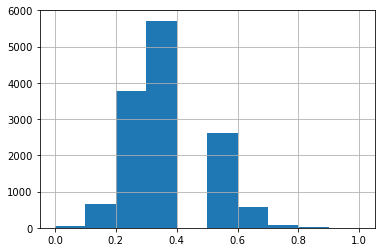

In [19]:
train_scaled.bedroomcnt.hist()

<AxesSubplot:>

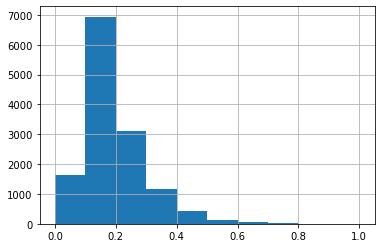

In [20]:
train_scaled.calculatedfinishedsquarefeet.hist()

<AxesSubplot:>

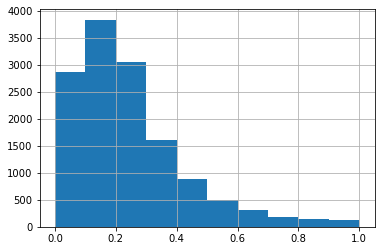

In [21]:
train_scaled.taxvaluedollarcnt.hist()

## Initial Observations:
    - Bathrooms are right skewed
    - Bedrooms are close to normally distributed 
    - Squarefeet and Tax value are very skewed...likely have some outliers that will want to be explored in second iteration 
    - Square feet may be the most important feature for predicting a property's value

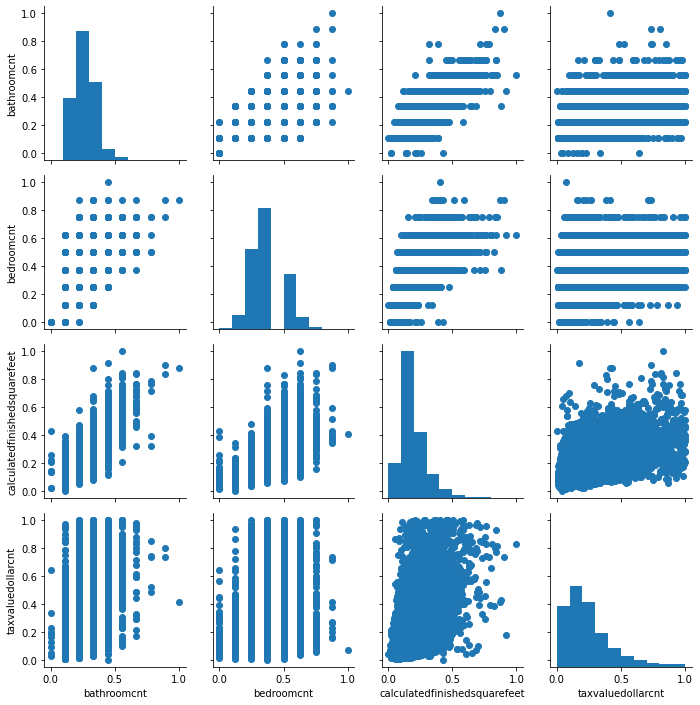

In [22]:
g = sns.PairGrid(train_scaled)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

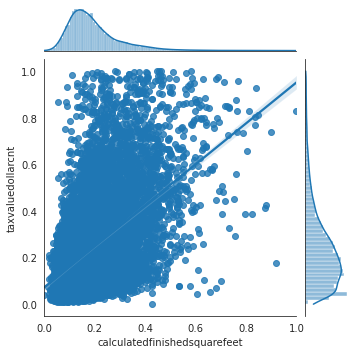

In [23]:
with sns.axes_style('white'):
    j = sns.jointplot("calculatedfinishedsquarefeet", "taxvaluedollarcnt", data=train_scaled, kind='reg', height=5);
plt.show()

(0.0, 4.0)

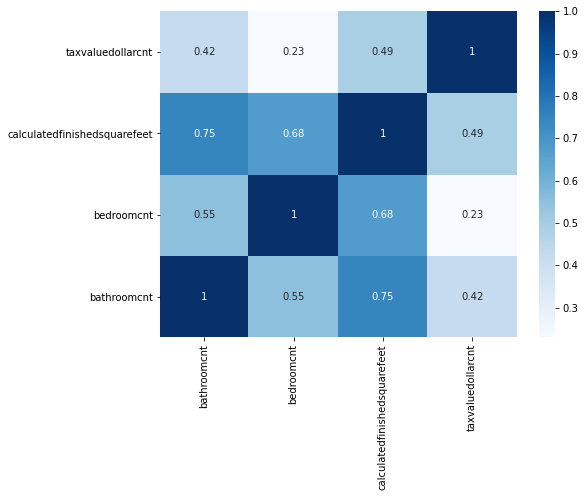

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(train_scaled.corr(), cmap='Blues', annot=True)
plt.ylim(0, 4)

## Takeaways after some visualizations:
- Expected upward trend in relationship between # of bedrooms and # of bathrooms
- Bedrooms and Bathrooms appear to correlate 
- Seems to be an outlier pulling down the slope of the regression line when comparing calculatedfinishedsquarefeet and taxvaluedollarcnt
- Squarefeet and bathrooms seems more closely related than squarefeet and bedrooms
    - This seems to make sense from my own experience. Some "bedrooms" can be very small. Bathrooms are more difficult to cut out squarefeet on. 


## Statistical Testing to run:
- Is there a correlation between squarefeet and tax value
- Bedrooms and Bathrooms seem to be tightly correlated. Test this.
    - Test to see if one is a better feature of value than the other. Do I need both?
    

### Correlation Test for Square Feet and Tax Value

H<sub>o</sub> = There is no linear correlation between a single unit property's value and the number of finished square feet. 

H<sub>*a*</sub> = There is a correlation between a property's value and square feet.

In [25]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_int = .95
a = 1 - confidence_int

In [26]:
corr, p = stats.pearsonr(train_scaled.calculatedfinishedsquarefeet, train_scaled.taxvaluedollarcnt)
print(f"Pearson's correlation coefficient is: {corr} and the p-value is: {p}")

if p < a:
    print("Reject the null hypothesis.")
    print("Move forward with the understanding that there is a correlation between square feet and  tax value.")
else:
    print("Fail to reject the null hypothesis. Proceed with an understanding that there is no linear correlation.")

Pearson's correlation coefficient is: 0.4942666352392237 and the p-value is: 0.0
Reject the null hypothesis.
Move forward with the understanding that there is a correlation between square feet and  tax value.


#### Takeaways:
    - There is a correlation of .43 and while not the strongest correlation coefficient, finishedsquarefeet will be a feature that I utililze going forward with into modeling. 

### Correlation Test for Bedrooms and Bathrooms

H<sub>o</sub> = There is no linear correlation between the number of bathrooms and the number of bedrooms for a single unit property. 

H<sub>*a*</sub> = There is a correlation between the number of batrhooms and the number of bedrooms.

In [27]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_int = .95
a = 1 - confidence_int

In [28]:
corr, p = stats.pearsonr(train_scaled.bathroomcnt, train_scaled.bedroomcnt)
print(f"Pearson's correlation coefficient is: {corr} and the p-value is: {p}")

if p < a:
    print("Reject the null hypothesis.")
    print("Move forward with the understanding that there is a correlation between bathroom and bedroom counts.")
else:
    print("Fail to reject the null hypothesis. Proceed with an understanding that there is no linear correlation.")

Pearson's correlation coefficient is: 0.5547983402446197 and the p-value is: 0.0
Reject the null hypothesis.
Move forward with the understanding that there is a correlation between bathroom and bedroom counts.


#### Takeaways:
    - A modest correlation between the bathroom and bedroom features exists.
    - Test to see if one feature is more correlated with taxvaluedollarcnt than the other.

### Correlation Test for Bedrooms and Value

H<sub>o</sub> = There is no linear correlation between the number of bedrooms for a single unit property and the property's value. 

H<sub>*a*</sub> = There is a correlation between the number of bedrooms and a property's value.

In [29]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_int = .95
a = 1 - confidence_int

In [30]:
corr, p = stats.pearsonr(train_scaled.bedroomcnt, train_scaled.taxvaluedollarcnt)
print(f"Pearson's correlation coefficient is: {corr} and the p-value is: {p}")

if p < a:
    print("Reject the null hypothesis.")
    print("Move forward with the understanding that there is a correlation between bedroom count and property value.")
else:
    print("Fail to reject the null hypothesis. Proceed with an understanding that there is no linear correlation.")

Pearson's correlation coefficient is: 0.2301789314716149 and the p-value is: 1.2037669505495235e-161
Reject the null hypothesis.
Move forward with the understanding that there is a correlation between bedroom count and property value.


#### Takeaways:
    - Weaker correlation coefficient for bedroom count and property value than the correlation for square feet and property value. 
    - Still, bedroom count is a feature that I will proceed with as a driver for property value going into modeling.

### Correlation Test for Bathrooms and Value

H<sub>o</sub> = There is no linear correlation between the number of bathrooms for a single unit property and the property's value. 

H<sub>*a*</sub> = There is a correlation between the number of bathrooms and a property's value.

In [31]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_int = .95
a = 1 - confidence_int

corr, p = stats.pearsonr(train_scaled.bathroomcnt, train_scaled.taxvaluedollarcnt)
print(f"Pearson's correlation coefficient is: {corr} and the p-value is: {p}")

if p < a:
    print("Reject the null hypothesis.")
    print("Move forward with the understanding that there is a correlation between bathroom count and property value.")
else:
    print("Fail to reject the null hypothesis. Proceed with an understanding that there is no linear correlation.")


Pearson's correlation coefficient is: 0.42336404413485895 and the p-value is: 0.0
Reject the null hypothesis.
Move forward with the understanding that there is a correlation between bathroom count and property value.


#### Takeaways:
    - The number of bathrooms is more correlated with a property's value than bedrooms.
        - This is aligned with one of my initial hypotheses...
            - Could be due to the fact that there is greater variance in bedroom square footage than bathroom square footage? If I had that data, that might be interesting to look at...
    - Proceed with bathrooms as a feature for predicting a property's tax value

## Modeling

In [32]:
# Create X & y version of train, where y is a series with just the target variable and X are all the features. 
X_train = train_scaled.drop(columns=['taxvaluedollarcnt'])
y_train = train.taxvaluedollarcnt

X_validate = validate_scaled.drop(columns=['taxvaluedollarcnt'])
y_validate = validate.taxvaluedollarcnt

X_test = test_scaled.drop(columns=['taxvaluedollarcnt'])
y_test = test.taxvaluedollarcnt

### Baseline Model

In [33]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict taxvaluedollarcnt_pred_mean
taxvaluedollarcnt_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['taxvaluedollarcnt_pred_mean'] = taxvaluedollarcnt_pred_mean
y_validate['taxvaluedollarcnt_pred_mean'] = taxvaluedollarcnt_pred_mean

# 2. compute taxvaluedollarcnt_pred_median
taxvaluedollarcnt_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['taxvaluedollarcnt_pred_median'] = taxvaluedollarcnt_pred_median
y_validate['taxvaluedollarcnt_pred_median'] = taxvaluedollarcnt_pred_median

In [34]:
#Evaluate the baseline model using the mean
evaluate.baseline_mean_errors(y_train.taxvaluedollarcnt)

{'sse': 1148759585740400.5,
 'mse': 85181639162.12372,
 'rmse': 291858.9370948296}

In [35]:
#Evaluate the baseline model using the median
evaluate.baseline_median_errors(y_train.taxvaluedollarcnt)

{'sse': 1209080157064621.0,
 'mse': 89654468119.87402,
 'rmse': 299423.5597274771}

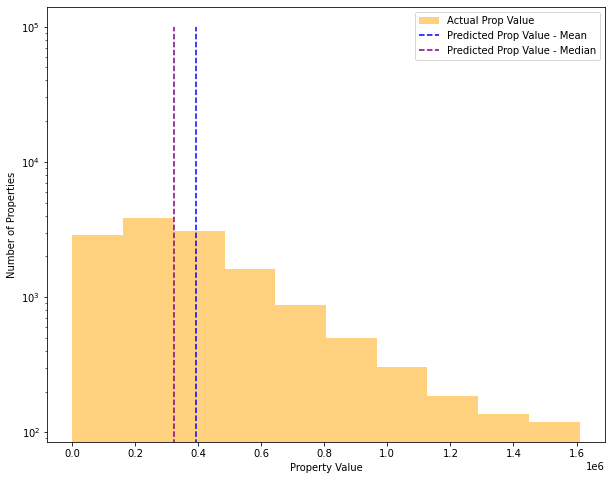

In [36]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(10, 8))
plt.hist(y_train.taxvaluedollarcnt, color='orange', alpha=.5, label="Actual Prop Value", log=True)
plt.vlines(y_train.taxvaluedollarcnt.mean(), 0, 10**5,  ls='--', color='blue', label="Predicted Prop Value - Mean")
plt.vlines(y_train.taxvaluedollarcnt.median(), 0, 10**5,  ls='--', color='purple', label="Predicted Prop Value - Median")
plt.xlabel("Property Value")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

In [37]:
evaluate.baseline_mean_errors(y_train.taxvaluedollarcnt)

{'sse': 1148759585740400.5,
 'mse': 85181639162.12372,
 'rmse': 291858.9370948296}

In [38]:
#Now that I have established the mean as the baseline, I will drop the median and rename baseline to yhat_baseline
y_train.drop(columns={'taxvaluedollarcnt_pred_median'}, inplace=True)
y_validate.drop(columns={'taxvaluedollarcnt_pred_median'}, inplace=True)
y_train.head()

,taxvaluedollarcnt,taxvaluedollarcnt_pred_mean
parcelid,,
11348913,557064.000,391522.212
12507741,300258.000,391522.212
12213784,20865.000,391522.212
11628655,401186.000,391522.212
10981423,1075000.000,391522.212


In [39]:
y_train.rename(columns={'taxvaluedollarcnt_pred_mean': 'yhat_baseline'}, inplace=True)
y_validate.rename(columns={'taxvaluedollarcnt_pred_mean': 'yhat_baseline'}, inplace=True)
y_train.head()

,taxvaluedollarcnt,yhat_baseline
parcelid,,
11348913,557064.000,391522.212
12507741,300258.000,391522.212
12213784,20865.000,391522.212
11628655,401186.000,391522.212
10981423,1075000.000,391522.212


#### Takeaways:
    - The basline model performs very poorly with either the median or the mean.
    - The mean performs slightly better, so I will go with that as the baseline model.

### LinearRegression (OLS) Model

In [40]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['yhat_lm'] = lm.predict(X_train)

# compute residuals
y_train['residual'] = y_train['yhat_lm'] - y_train['taxvaluedollarcnt']
y_train['baseline_residual'] = y_train['yhat_baseline'] - y_train['taxvaluedollarcnt']

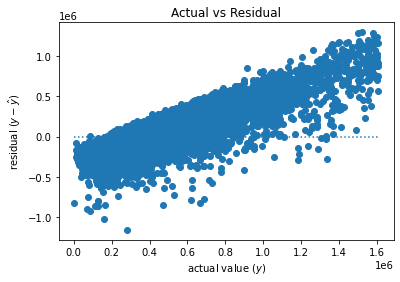

In [41]:
#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.taxvaluedollarcnt, y_train.yhat_lm)

In [42]:
#Retrieve evaluation metrics for Linear Regression Model on in-sample data
evaluate.regression_errors(y_train.taxvaluedollarcnt, y_train.yhat_lm)

sse     835328277740062.250
ess     313431308000338.000
tss    1148759585740400.500
mse         61940403213.708
rmse             248878.290
r^2                   0.273
dtype: float64

In [43]:
rs = 313431308000338.000/1148759585740400.500
print(f"{rs:.2%} of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet")

27.28% of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet


In [44]:
#Does this model perform better than the baseline model on in-sample data?
evaluate.better_than_baseline(y_train.taxvaluedollarcnt, y_train.yhat_lm)

True

In [45]:
#How does this model perform on out of sample data?

# predict train
y_validate['yhat_lm'] = lm.predict(X_validate)

# compute residuals
y_validate['residual'] = y_validate['yhat_lm'] - y_validate['taxvaluedollarcnt']
y_validate['baseline_residual'] = y_validate['yhat_baseline'] - y_validate['taxvaluedollarcnt']

#Retrieve evaluation metrics
evaluate.regression_errors(y_validate.taxvaluedollarcnt, y_validate.yhat_lm)

sse    364727349777535.938
ess    143804208567650.438
tss    500857407139901.875
mse        63090702262.158
rmse            251178.626
r^2                  0.287
dtype: float64

In [46]:
rs = 143804208567650.438/500857407139901.875
print(f"{rs:.2%} of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet")

28.71% of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet


In [47]:
#Does this model perform better than the baseline model on out of sample data?
evaluate.better_than_baseline(y_validate.taxvaluedollarcnt, y_validate.yhat_lm)

True

### Lasso Lars Model

In [48]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['yhat_lars'] = lars.predict(X_train)

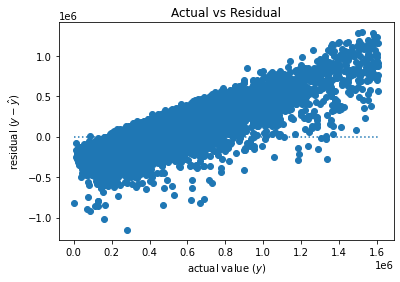

In [49]:
#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.taxvaluedollarcnt, y_train.yhat_lars)

In [50]:
#Retrieve evaluation metrics for Lasso + Lars Model on in-sample data
evaluate.regression_errors(y_train.taxvaluedollarcnt, y_train.yhat_lars)

sse     835329464862512.250
ess     312636900165139.500
tss    1148759585740400.500
mse         61940491239.991
rmse             248878.467
r^2                   0.272
dtype: float64

In [51]:
rs = 312636900165139.500/1148759585740400.500
print(f"{rs:.2%} of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet")

27.22% of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet


In [52]:
#Does Lassor + Lars perform better than baseline on in-sample data?
evaluate.better_than_baseline(y_train.taxvaluedollarcnt, y_train.yhat_lars)

True

In [53]:
#How does the model perform on out of sample data?

# predict on validate
y_validate['yhat_lars'] = lars.predict(X_validate)

#Retrieve evaluation metrics for Lasso + Lars Model on out of sample data
evaluate.regression_errors(y_validate.taxvaluedollarcnt, y_validate.yhat_lars)

sse    364714662803249.625
ess    143431773982830.312
tss    500857407139901.875
mse        63088507663.596
rmse            251174.258
r^2                  0.286
dtype: float64

In [54]:
rs = 143431773982830.312/500857407139901.875
print(f"{rs:.2%} of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet")

28.64% of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet


In [55]:
#Does Lassor + Lars perform better than baseline on in-sample data?
evaluate.better_than_baseline(y_validate.taxvaluedollarcnt, y_validate.yhat_lars)

True

### TweedieRegressor (GLM) Model

In [56]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['yhat_glm'] = glm.predict(X_train)

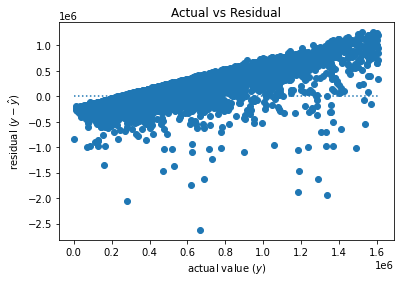

In [57]:
#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.taxvaluedollarcnt, y_train.yhat_glm)

In [58]:
#How does the GLM model perform on in-sample data?
evaluate.regression_errors(y_train.taxvaluedollarcnt, y_train.yhat_glm)

sse     897293643503833.750
ess     357771400307920.125
tss    1148759585740400.500
mse         66535195276.867
rmse             257944.171
r^2                   0.311
dtype: float64

In [59]:
rs = 357771400307920.125/1148759585740400.500
print(f"{rs:.2%} of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet")

31.14% of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet


In [60]:
#Does the GLM model perform better than baseline on in-sample data?
evaluate.better_than_baseline(y_train.taxvaluedollarcnt, y_train.yhat_glm)

True

In [61]:
# predict train
y_validate['yhat_glm'] = glm.predict(X_validate)

In [62]:
#How does the GLM model perform on out of sample data?
evaluate.regression_errors(y_validate.taxvaluedollarcnt, y_validate.yhat_glm)

sse    404101382990812.000
ess    182726338920369.188
tss    500857407139901.875
mse        69901640372.048
rmse            264389.184
r^2                  0.365
dtype: float64

In [63]:
rs = 182726338920369.188/500857407139901.875
print(f"{rs:.2%} of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet")

36.48% of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet


In [64]:
#Does the GLM model perform better than baseline on out of sample data?
evaluate.better_than_baseline(y_validate.taxvaluedollarcnt, y_validate.yhat_glm)

True

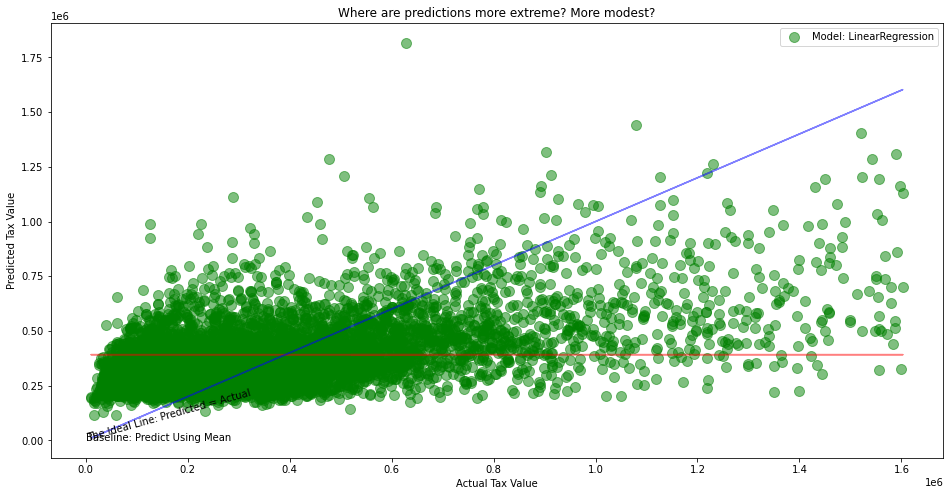

In [65]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.yhat_baseline, alpha=.5, color="red", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_lm, 
            alpha=.5, color='green', s=100, label="Model: LinearRegression")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

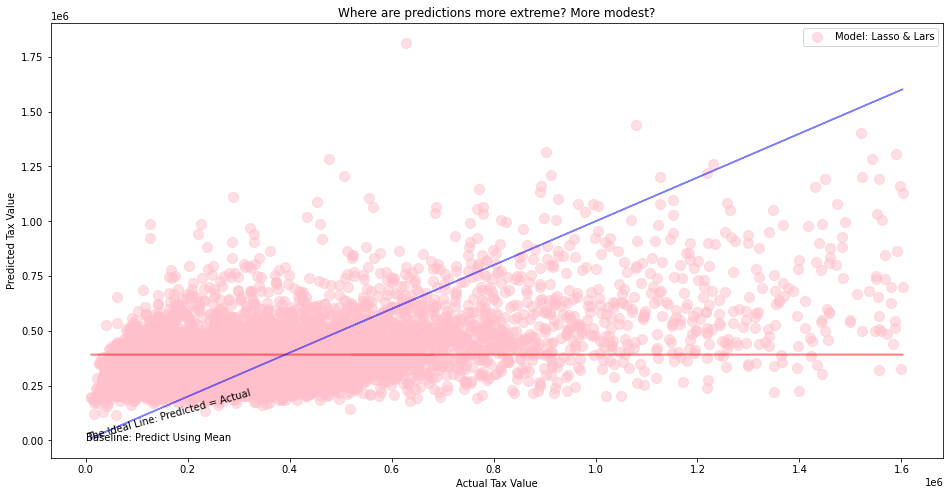

In [66]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.yhat_baseline, alpha=.5, color="red", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_lars, 
            alpha=.5, color="pink", s=100, label="Model: Lasso & Lars")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

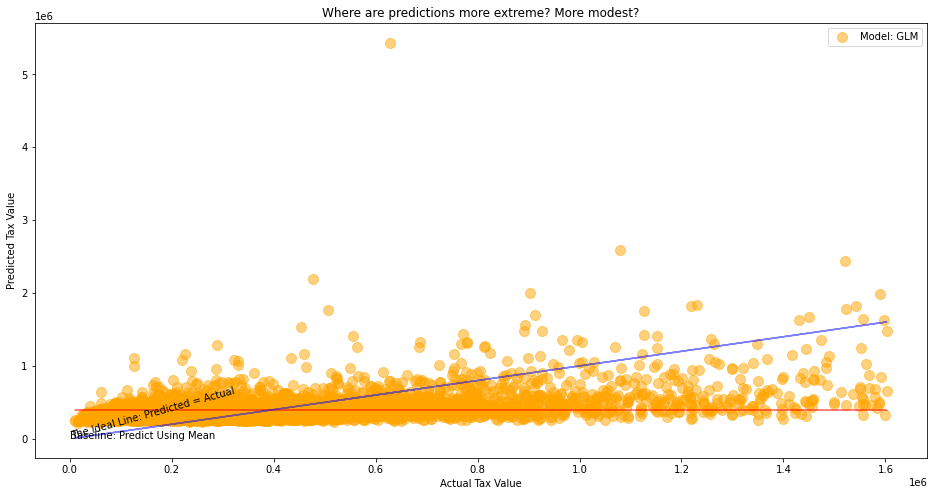

In [67]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.yhat_baseline, alpha=.5, color="red", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_glm, 
            alpha=.5, color="orange", s=100, label="Model: GLM")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

#### Takeaways:
    - Tweedie Regressor Model did not beat baseline on unscaled data. It DID beat baseline on scaled data.
    - Tweedie Regressor Model can explain more of the variance than other models.
    - LM model has the lowest of the RMSE scores, but does not have as high as the GLM r^2
    
    - The above is true from the modeling done with scaled data and using 3 when calculating the upper and lower bounds for outliers.
    
    - How do the models perform when I change how I handle outliers and drop to 1.5?
        - All models perform better when using 3 and expanding what outliers are included.
    

---